In [1]:
import os                   # to interact with the operating system
import glob

import numpy as np
import pandas as pd
import xarray as xr

import pop_tools
import cftime
import csv

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.feature as cfeature
import matplotlib.cm as cm
import cmocean.cm as cmo
import matplotlib.ticker as ticker
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches


ccrs = cartopy.crs

In [2]:
nature_coast = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='darkgray')

In [3]:
labelsize = 20

# Describe streamfunction metrics

## BSF

In [4]:
# setting up of regional mask
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [15.0, 66.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}        
    ]}
maskBSF = pop_tools.region_mask_3d(grid_name, 
                                  region_defs=region_defs, 
                                  mask_name='Subpolar Gyre')
maskBSF = maskBSF.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
#bsf_file = os.path.expanduser('~/phase1_CONDA/')+'/results/composites/BSF_anomaly.nc'
#anom_bsf_ds = xr.open_dataarray(bsf_file).roll(nlon=+100).where(maskBSF == 1)

bsf_ds = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/BSFcomposite-test.nc').roll(nlon=+100).where(maskBSF == 1)

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_temp = xr.open_dataset(temp_file).isel(time=0, z_t=0).squeeze().roll(nlon=+100).where(maskBSF == 1)

replacement_value = 0
ds_temp['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_temp['ULAT']), np.isinf(ds_temp['ULAT']) | np.ma.getmask(ds_temp['ULAT'])),
    replacement_value,
    ds_temp['ULAT']
)

ds_temp['ULONG'] = xr.where(
    np.logical_or(np.isnan(ds_temp['ULONG']), np.isinf(ds_temp['ULONG']) | np.ma.getmask(ds_temp['ULONG'])),
    replacement_value,
    ds_temp['ULONG']
)

In [11]:
vmin = -60
vmax = -vmin

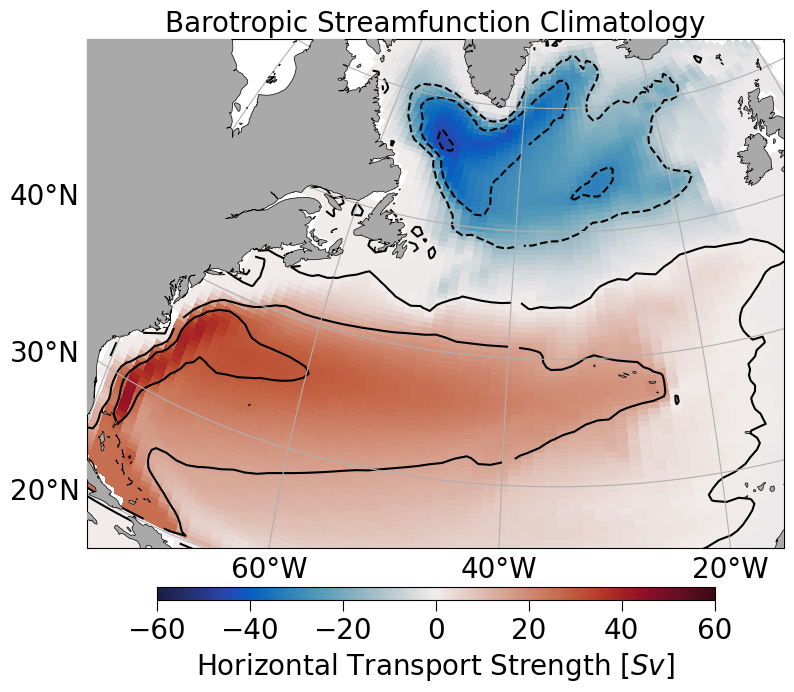

In [13]:
cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Horizontal Transport Strength [$Sv$]', 'pad': 0.05}

fig, ax = plt.subplots(figsize=(9, 10), subplot_kw={'projection': ccrs.Orthographic(central_latitude=40, central_longitude=-35)})
ax.set_extent([-80, -15, 25, 60], crs=ccrs.PlateCarree())

pc = ax.pcolormesh(ds_temp.ULONG, ds_temp.ULAT, bsf_ds.isel(time=slice(0,40)).mean('time'), 
                   transform=ccrs.PlateCarree(),
                   cmap=cmo.balance, vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)

ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)

gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
gl.xlabel_style = {'size': labelsize}
gl.ylabel_style = {'size': labelsize}

plt.contour(ds_temp.ULONG, ds_temp.ULAT, bsf_ds.isel(time=slice(0,40)).mean('time'), 
                   transform=ccrs.PlateCarree(), colors='k')
ax.add_feature(cartopy.feature.NaturalEarthFeature('physical', 'land', '50m',linewidth=0.5, edgecolor='black', facecolor='darkgray'), zorder=10)
ax.set_title('Barotropic Streamfunction Climatology', fontsize=labelsize)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'climatology_bsf.png', bbox_inches='tight', dpi=300, transparent=True)

## dMOC

In [14]:
#dmoc_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/dMOC_anomaly.nc'
#anom_dmoc_ds = xr.open_dataarray(dmoc_file)

dmoc_ds = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/dMOCcomposite-test.nc')

ps_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'

ds_ps = xr.open_dataset(ps_file).isel(time=0, nlon=0).squeeze()
replacement_value = 0

ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT'])

ds_ps['z_t'] = ds_ps.z_t *1e-2

In [19]:
vmin = -30
vmax = -vmin

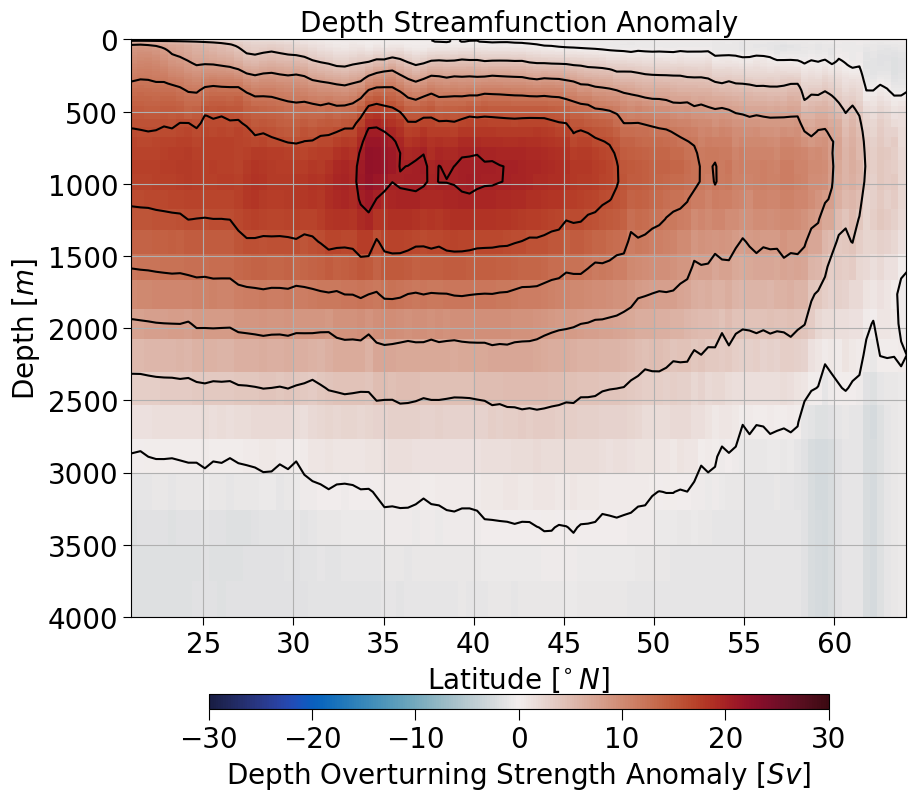

In [25]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Depth Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.ULAT, ds_ps.z_t, dmoc_ds.isel(time=slice(0,40)).mean('time'),
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)

plt.contour(ds_ps.ULAT, ds_ps.z_t, dmoc_ds.isel(time=slice(0,40)).mean('time'), colors='k')

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize, size=8)

ax.tick_params(axis='both', which='both', labelsize=labelsize, size=6)
ax.set_title('Depth Streamfunction Anomaly', fontsize=labelsize)


ax.invert_yaxis()
ax.set_xlim([21, 64]) 

ax.set_ylim([4000, 0]) 
plt.grid()


plt.ylabel(r'Depth [$m$]', fontsize = labelsize)
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize)

#plt.show()

plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'climatology_dmoc.png', bbox_inches='tight', dpi=300, transparent=True)

## sMOC

In [27]:
smoc_ds = xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/sMOCcomposite.nc')

temp_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_ps = xr.open_dataset(temp_file).isel(time=0, nlon=0).squeeze()

replacement_value = 0


# Replace non-finite values and masked values
ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT']
)

#smoc_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composites/sMOC_anomaly.nc'
#anom_smoc_ds = xr.open_dataset(smoc_file)

In [30]:
vmin = -30
vmax = -vmin

sigma_level =[12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4,
                   33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 
                   36.4, 36.42, 36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 
                   36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 
                   36.78, 36.8, 36.82, 36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 
                   37.14, 37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
fake_sigma = np.arange(len(sigma_level))

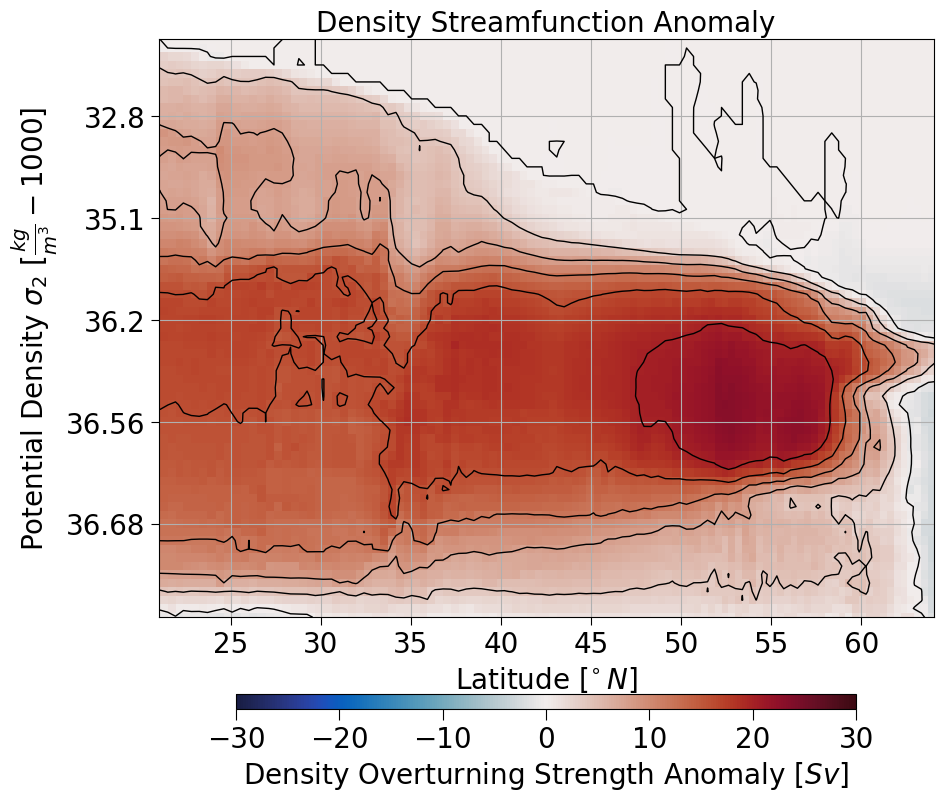

In [33]:
labelsize = 20

cbar_kwargs = {'orientation': 'horizontal', 'shrink': 0.8, 'aspect': 40,
               'label': 'Density Overturning Strength Anomaly [$Sv$]', 'pad': 0.1}

fig, ax = plt.subplots(figsize=(10, 10))

pc = ax.pcolormesh(ds_ps.TLAT.isel(nlat=(slice(250,365))), fake_sigma, smoc_ds.densMOC.isel(time=slice(0,40)).mean('time'),
                   cmap=cmo.balance,
                   vmin=vmin, vmax=vmax)

cbar = plt.colorbar(pc, **cbar_kwargs)
cbar.ax.xaxis.label.set_size(labelsize)
cbar.ax.tick_params(axis='x', labelsize=labelsize , size=8)

plt.contour(ds_ps.ULAT.isel(nlat=(slice(250,365))), fake_sigma, smoc_ds.densMOC.isel(time=slice(0,40)).mean('time'), 
            linewidths=1, colors='k')

ax.tick_params(axis='both', which='both', labelsize=labelsize , size=6)
ax.set_title('Density Streamfunction Anomaly', fontsize=labelsize )

plt.yticks(np.arange(len(sigma_level))[::12], sigma_level[::12])

ax.set_xlim([21, 64])  
ax.set_ylim([15, 83])  

plt.ylabel(r'Potential Density $\sigma_2$ [$\frac{kg}{m^3} -1000$]', fontsize = labelsize )
plt.xlabel(r'Latitude [$^{\circ}\,N$]', fontsize = labelsize )

plt.gca().invert_yaxis()

plt.grid()

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'climatology_smoc.png', bbox_inches='tight', dpi=300, transparent=True)

## sMOC all members time series

In [4]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/all_member_timeseries/'
files = sorted(glob.glob(os.path.join(path, '*monthly_smoc55_member_*.nc')))

In [5]:
annual_means = []

for file in files:
    ds = xr.open_dataset(file)
    monthly_mean = ds.__xarray_dataarray_variable__
    annual_mean = monthly_mean.resample(time='1Y').mean().values
    annual_means.append(annual_mean)
    
# Find the maximum length of all arrays
max_length = max(len(arr) for arr in annual_means)

# Pad arrays to the same length
annual_means_padded = []
for arr in annual_means:
    if len(arr) < max_length:
        padded_arr = np.pad(arr, (0, max_length - len(arr)), constant_values=np.nan)
    else:
        padded_arr = arr
    annual_means_padded.append(padded_arr)

# Convert the list of padded arrays to a NumPy array
annual_means_array = np.stack(annual_means_padded, axis=0)

ensemble_mean = np.nanmean(annual_means_array, axis=0)

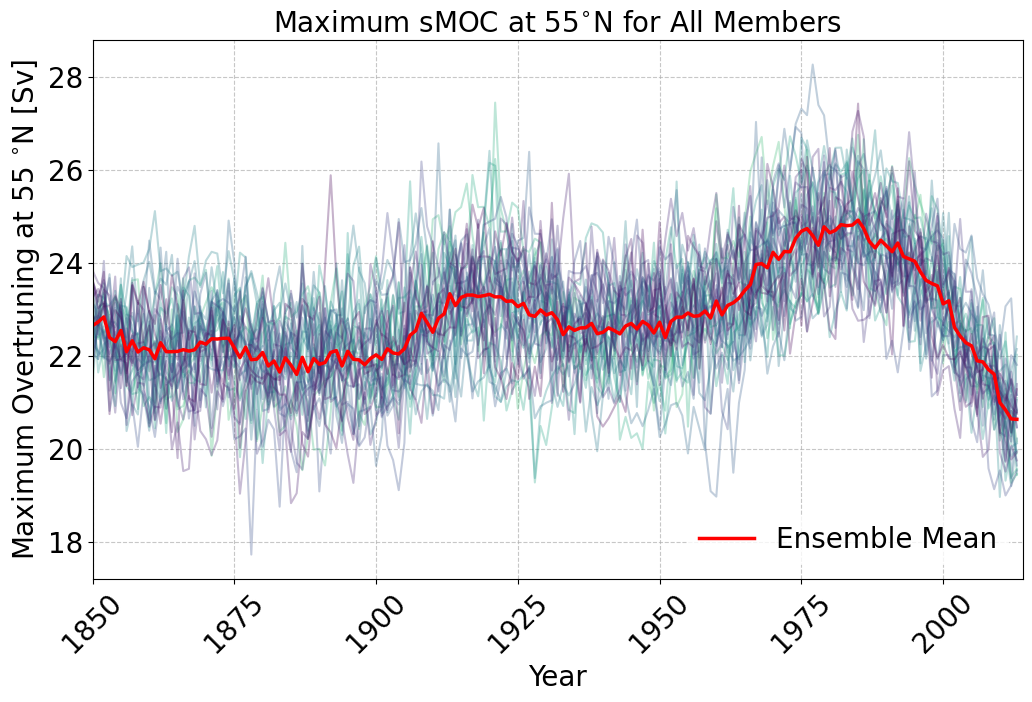

In [19]:
# Use the viridis colormap to assign colors to the annual means
colors = cm.viridis_r(np.linspace(0.3, 1, len(annual_means_array)))

plt.figure(figsize=(12, 7))

# Plot each annual mean with a different color from the 'colors' array
for idx, annual_mean in enumerate(annual_means_array):
    plt.plot(annual_mean[:164], alpha=0.3, color=colors[idx])

# Plot the ensemble mean in 'red' and make it stand out
plt.plot(ensemble_mean[:164], color='red', linewidth=2.5, label='Ensemble Mean')

# Adding a title and axis labels with the specified labelsize
plt.title(r'Maximum sMOC at 55$^{\circ}$N for All Members', fontsize=labelsize)
plt.xlabel('Year', fontsize=labelsize)
plt.ylabel('Maximum Overtruning at 55 $^{\circ}$N [Sv]', fontsize=labelsize)

# Adjusting the x-axis from 1850 to 2010 with the specified labelsize for ticks
plt.xlim(0, 164)
plt.xticks(ticks=np.arange(0, 165, 25), labels=np.arange(1850, 2015, 25), fontsize=labelsize, rotation=45)
plt.yticks(fontsize=labelsize)

# Add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding a legend with the specified labelsize, white background, and no border
legend = plt.legend(fontsize=labelsize, frameon=True, facecolor='white', edgecolor='white', loc='lower right')
legend.get_frame().set_linewidth(0)

# Show the plot
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'all_members_annual_smoc.png', bbox_inches='tight', dpi=300, transparent=True)

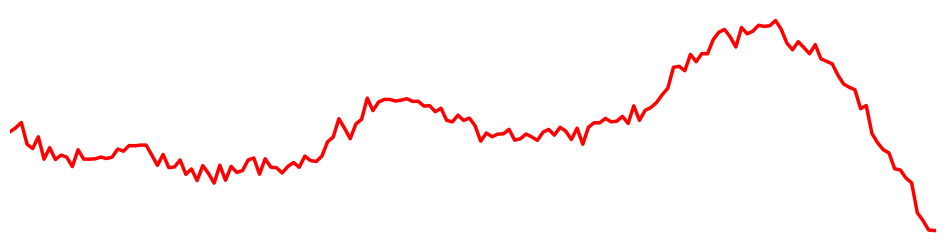

In [24]:
plt.figure(figsize=(12, 3), facecolor='none')

# Plot the ensemble mean in 'red' and make it stand out
plt.plot(ensemble_mean[:164], color='red', linewidth=2.5)

# Remove axis ticks, labels, and spines to achieve a transparent background
ax = plt.gca()
ax.set_facecolor('none')  # Set the axes background to transparent
ax.get_xaxis().set_visible(False)  # Hide the x-axis
ax.get_yaxis().set_visible(False)  # Hide the y-axis
for spine in ax.spines.values():
    spine.set_visible(False)  # Hide the spines

# Adjust the x-axis from 1850 to 2010
plt.xlim(0, 164)

# Show the plot with a transparent background
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'line_mean_annual_smoc.png', bbox_inches='tight', dpi=300, transparent=True)

## Method

In [5]:
def transport_events(raw_files, h, window_size=40, duration_threshold=20, threshold_multiple=3):
    def find_corresponding_file_name(vvel_number_to_find):
        with open(os.path.expanduser('~/phase1_CONDA/timeseries/order.txt'), 'r') as file:
            vvel_list = file.readlines()
        vvel_dict = {filename.split()[1]: int(filename.split()[0]) for filename in vvel_list}
        vvel_filename = None
        for filename in vvel_list:
            if vvel_dict[filename.split()[1]] == vvel_number_to_find:
                vvel_filename = filename.split()[1]  
                break
        return vvel_filename
    
    # Load data
    signals = np.load(raw_files[h])
    hist_end = (2014 - 1850) * 12
    signals = signals[:hist_end]
    time_annual = np.arange(1850, 1850 + (hist_end / 12))

    # Define criteria_indices_dict
    criteria_indices_dict = {}

    # Iterate over each time series
    for i, signal in enumerate(signals.T):
        # Calculate annual means
        annual_means = np.mean(signal.reshape(-1, 12), axis=1)

        # Find criteria indices
        criteria_indices = []
        for j in range(window_size, len(annual_means) - duration_threshold):
            window = annual_means[j - window_size:j]
            std_window = np.std(window)
            avg_window = np.mean(window)

            threshold = annual_means[j:j + duration_threshold]
            avg_threshold = np.mean(threshold)

            if avg_threshold >= avg_window + (threshold_multiple * std_window) or \
                    avg_threshold <= avg_window - (threshold_multiple * std_window):
                if len(criteria_indices) == 0 or j >= criteria_indices[-1] + duration_threshold:
                    criteria_indices.append(j)

        criteria_indices_dict[i] = criteria_indices

    # Filter out non-empty criteria indices
    result = [(index, value) for index, value in criteria_indices_dict.items() if value]

    # Write results to CSV
    with open('events_dens_spg.csv', 'w', newline='') as csvfile:
        fieldnames = ['Index', 'Values']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for index, values in result:
            writer.writerow({'Index': index, 'Values': values[0]})
                
    # Save event and member_name
    saved_data = []
    for index, values in result:
        file_name = find_corresponding_file_name(index)[5:-3]
        annual_means = np.mean(signals[:, index].reshape(-1, 12), axis=1)
        
        start = values[0]
        end = values[0] + duration_threshold
        event = annual_means[start - window_size:end]
        
        
        saved_data.append((file_name, event))
        
    return saved_data

In [8]:
raw_files = glob.glob(os.path.expanduser('~/phase1_CONDA/') + 'timeseries/*time_series.npy')
saved_data = transport_events(raw_files, h=7)
sorted_data = sorted(saved_data, key=lambda x: x[0])

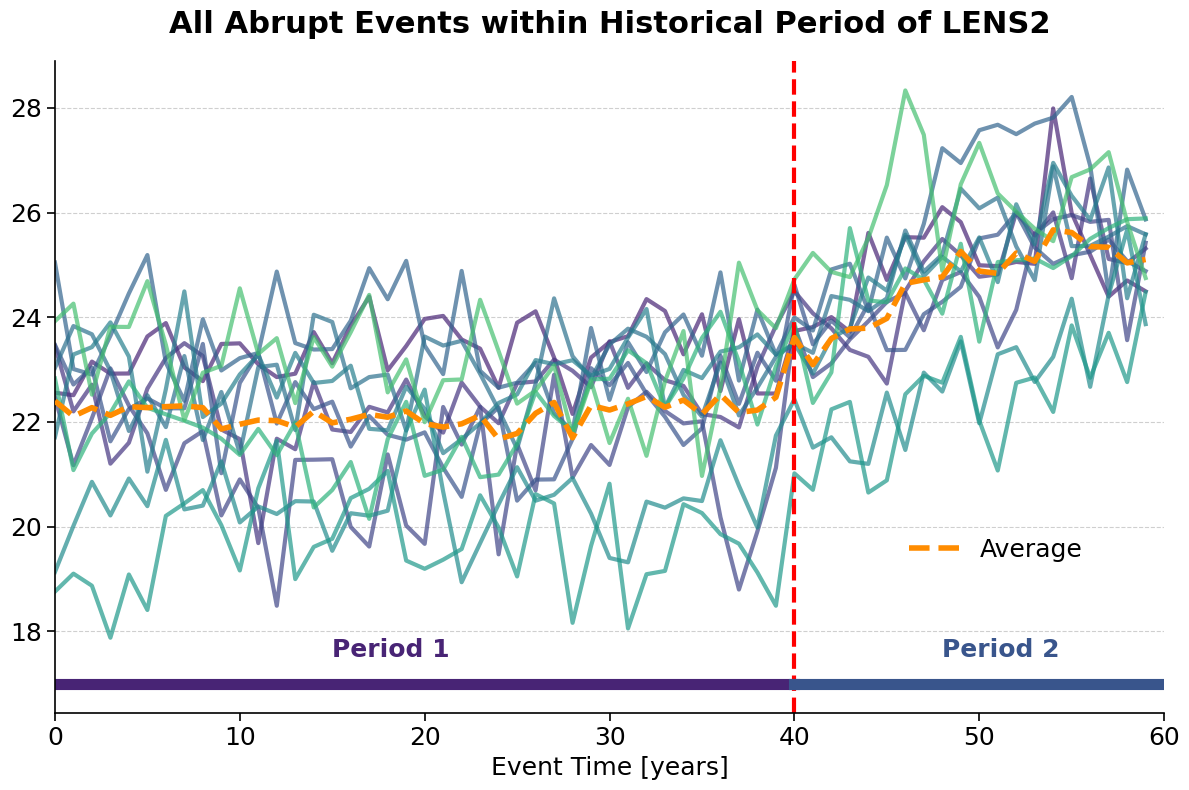

In [42]:
# Create the figure
fig, ax = plt.subplots(figsize=(12, 8))

colors = cm.viridis(np.linspace(0.1, 0.7, len(sorted_data[1:])))

time_series_list = []

# Add each time series to the plot and list
for (file_name, timeseries), color in zip(sorted_data[1:], colors):
    if file_name != "1301.001":
        ax.plot(timeseries, color=color, linewidth=3, alpha=0.7)
        time_series_list.append(timeseries)

# Ensure time_series_list contains the same length series
# Calculate the mean time series
if time_series_list and all(len(series) == len(time_series_list[0]) for series in time_series_list):
    mean_time_series = np.mean(time_series_list, axis=0)
    
    # Plot the mean time series
    
    ax.plot(mean_time_series, label='Average', linestyle='--', color='darkorange', linewidth=4, zorder=110)

# Add Event and Period Markers and Texts
event_location = 40
length = 60
ax.axvline(x=event_location, color='r', linestyle='--', linewidth=3)
ax.axhline(y=17, color=colors[0], linewidth=8, xmin=(event_location - 40) / length, xmax=(event_location) / length)
ax.axhline(y=17, color=colors[3], linewidth=8, xmin=(event_location) / length, xmax=(event_location + 20) / length)
ax.text(15, 17.5, 'Period 1', weight='bold', color=colors[0], fontsize=labelsize)
ax.text(48, 17.5, 'Period 2', weight='bold', color=colors[3], fontsize=labelsize)

# Preset labelsize
labelsize = 18

# Set Title and Labels
ax.set_title(r'All Abrupt Events within Historical Period of LENS2', fontsize=labelsize + 4, pad=20, weight='bold')
ax.set_xlabel('Event Time [years]', fontsize=labelsize)
ax.tick_params(axis='x', labelsize=labelsize)
ax.tick_params(axis='y', labelsize=labelsize)
ax.grid(axis='y', linestyle='--', alpha=0.6)

# Set X-axis range from 0 to 60
ax.set_xlim(0, 60)

# Customize spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.tick_params(axis='both', length=6, width=1.2)

# Adding a legend with the specified labelsize, white background, and no border,
# positioned a bit highe5
legend = ax.legend(fontsize=labelsize, frameon=True, facecolor='white', edgecolor='white', loc='center left', bbox_to_anchor=(0.75, 0.25))
legend.get_frame().set_linewidth(0)

# Final layout adjustments
plt.tight_layout()

# Save and show plot
# fig.savefig(os.path.expanduser('~/phase1_CONDA/results/Method_2.png'), bbox_inches='tight', dpi=300, transparent=True)
plt.show()


## Animation of hydrographic variables

In [4]:
grid_name = 'POP_gx1v7'
region_defs = {
    'SubpolarAtlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [10.0, 80.0], 'TLONG': [260.0, 360.0]}}   
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}}]}
maskBSF = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='North Atlantic')
maskBSF = maskBSF.sum('region')  

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [19]:
variables = ['TEMP', 'SALT', 'SIGMA_2', 'HMXL']
labels = [r'Temperature Anomaly $\Delta$T [$^{\circ} C$]', 
          r'Haline Anomaly $\Delta$S [$\frac{g}{kg}$]', 
          r'Potential Density Anomaly $\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]',
          r'Mixed Layer Depth Anomaly $\Delta h$ [$m$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r, cmo.tarn]
vmins = [-0.9, -0.3, -0.2, -300]

In [20]:
files = sorted(glob.glob('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/composite*.nc'))

datasets = {var: xr.open_dataset('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/' + var + 'composite.nc').roll(nlon=+100) for var in variables}
replacement_value = 0
for ds in datasets.values():
    ds['TLAT'] = xr.where(
        np.logical_or(np.isnan(ds['TLAT']), np.isinf(ds['TLAT']) | np.ma.getmask(ds['TLAT'])),
        replacement_value,
        ds['TLAT'])
    ds['TLONG'] = xr.where(
        np.logical_or(np.isnan(ds['TLONG']), np.isinf(ds['TLONG']) | np.ma.getmask(ds['TLONG'])),
        replacement_value,
        ds['TLONG'])

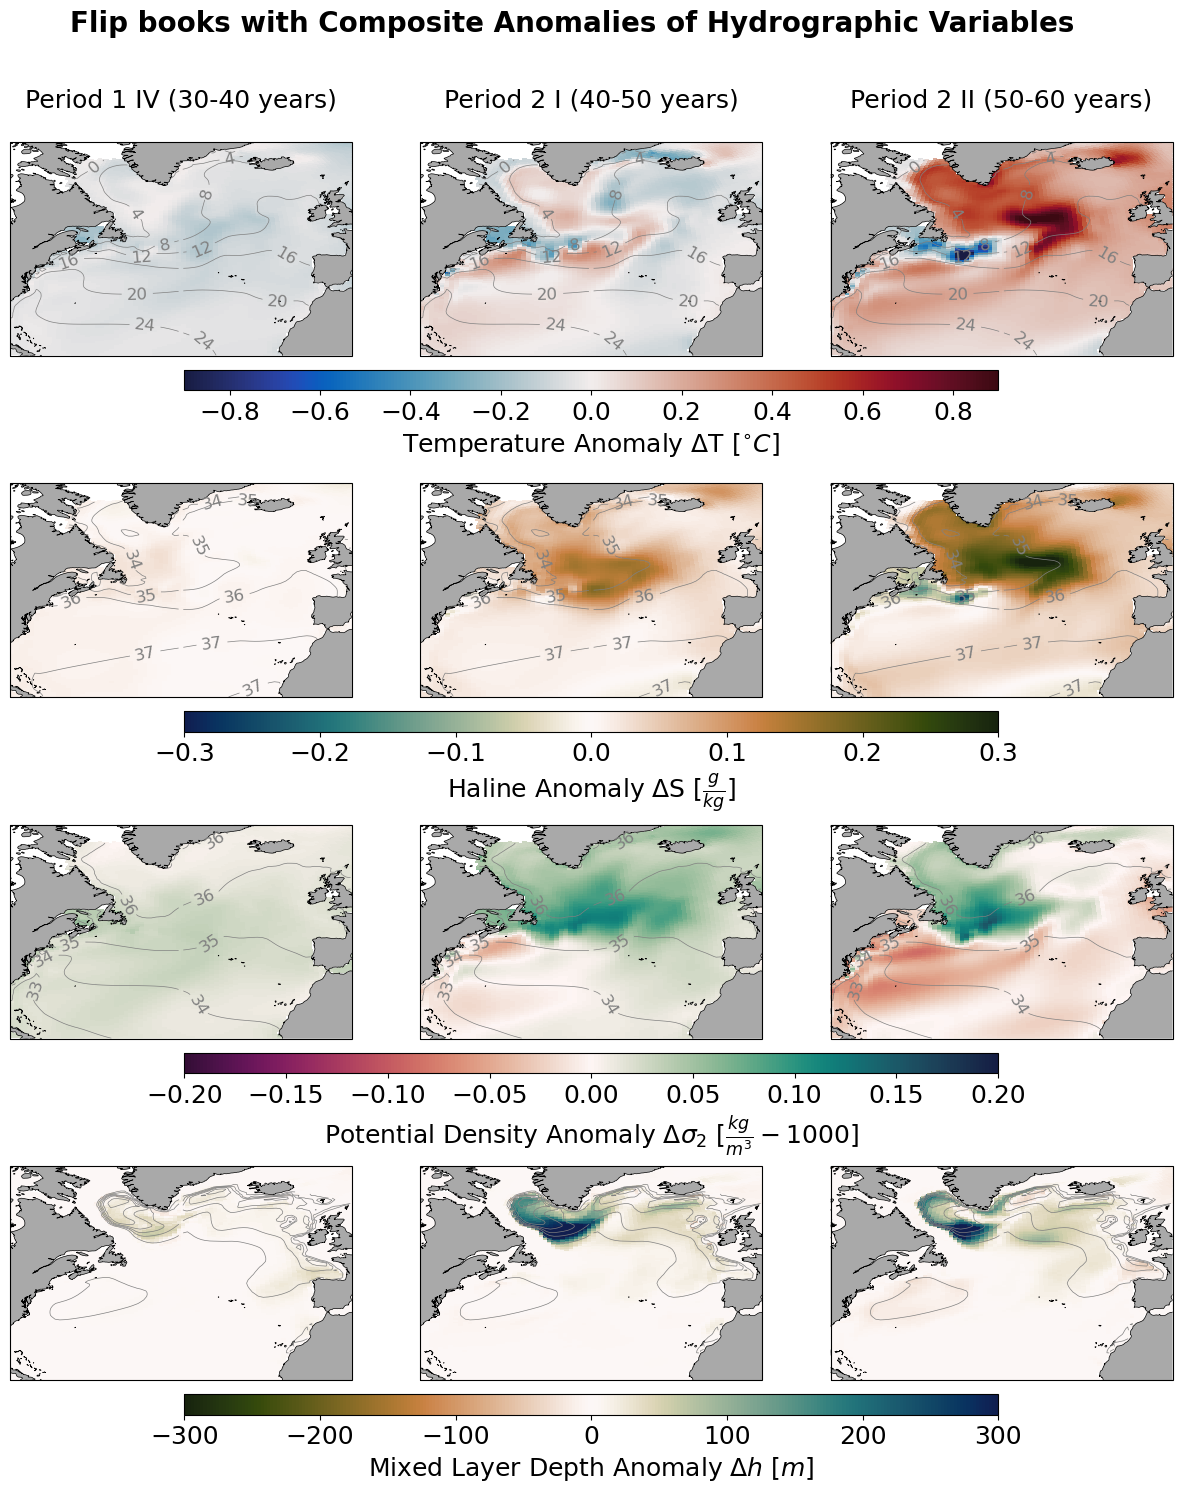

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 17), # (width, height)
                         subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=18)
years_ranges = [(30, 40), (40, 50), (50, 60)]
column_names = ['Period 1 IV (30-40 years)', 'Period 2 I (40-50 years)', 'Period 2 II (50-60 years)']

for row, var in enumerate(variables):
    
    if var == 'HMXL':
        ds_var_annual = datasets[var].roll(nlon=-100)/100
        ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
    else:
        ds_var_annual = datasets[var].sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean('z_t')
        ds = ds_var_annual - ds_var_annual.isel(time=slice(0,40)).mean('time')
        
    vmin = vmins[row]
    vmax = -vmin
    for col, (start, end) in enumerate(years_ranges):
        ax = axes[row, col]
        pc = ds[var].isel(time=range(start, end)).mean('time').plot.pcolormesh(
            ax=ax, 
            transform=ccrs.PlateCarree(),
            x='TLONG', 
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        ) 
        ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
        #ax.coastlines(linewidth=1.5, color='black', alpha=0.8)
        ax.add_feature(nature_coast)
        cs = ax.contour(
            ds.TLONG, ds.TLAT, ds_var_annual[var].isel(time=slice(0, 40)).mean('time').where(maskBSF == 1), 
            linewidths=0.5, colors='gray', transform=ccrs.PlateCarree()
        )
        if var == 'TEMP' or var == 'SALT' or var == 'SIGMA_2':
            ax.clabel(cs, fmt='%1.0f', inline=True, fontsize=12)
    cbar = fig.colorbar(pc, ax=axes[row, :], orientation='horizontal', label=labels[row], aspect=40, pad=0.05, shrink=0.7)
    
for col, name in enumerate(column_names):
    axes[0, col].set_title(name, fontsize=18, pad=25)
fig.suptitle('Flip books with Composite Anomalies of Hydrographic Variables', fontsize=20, fontweight='bold', x=0.5, y=0.95) # bottom-left (0, 0) and top-right (1, 1)

#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/')+'Figure_5.png', bbox_inches='tight', dpi=300, transparent=True)

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

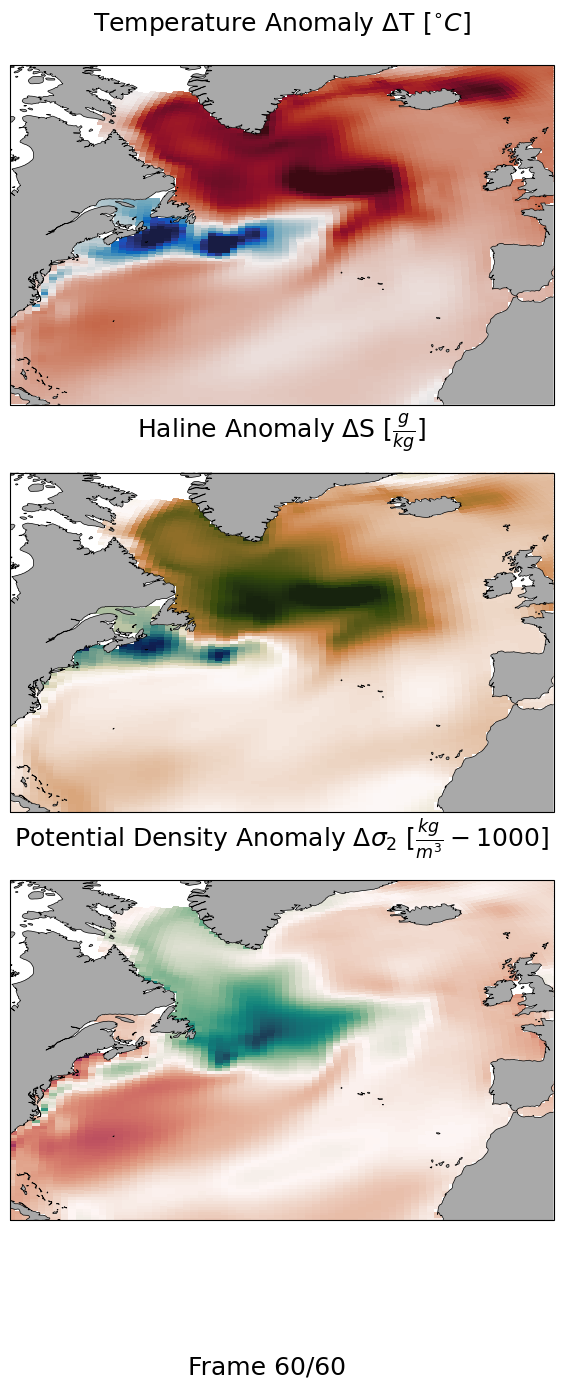

In [47]:
# Initialize Plot Elements
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 15), subplot_kw={'projection': ccrs.PlateCarree()})
plt.rc('font', size=labelsize)

# Initialize placeholders for plots
plots = []

for row in range(len(variables)):
    ax = axes[row]
    # Create an initial blank plot
    plot = ax.pcolormesh(np.zeros((10, 10)), vmin=vmins[row], vmax=-vmins[row], cmap=cmaps[row], transform=ccrs.PlateCarree())
    plots.append(plot)
    ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor='black')  # Adding coastlines
    ax.add_feature(nature_coast)
    ax.set_title(labels[row], fontsize=labelsize, pad=25)

fig.suptitle('Animation of Hydrographic Variable Anomalies', fontsize=labelsize, fontweight='bold', x=0.5, y=0.95)

# Define the animation update function
def update(frame):
    for row, var in enumerate(variables):
        ax = axes[row]
        ds_var_annual = datasets[var].sel(z_t=slice(5.0000000e+02, 1.050000e+04)).mean('z_t')
        ds = ds_var_annual - ds_var_annual.isel(time=slice(0, 40)).mean('time')
        vmin, vmax = vmins[row], -vmins[row]

        ax.clear()  # Clear the axes to remove old plot
        ax.set_extent([-80, 0, 20, 70], crs=ccrs.PlateCarree())
        #ax.add_feature(cfeature.COASTLINE, linewidth=1.5, edgecolor='black')
        ax.add_feature(nature_coast)

        # Update pcolormesh with actual data
        plots[row] = ds[var].isel(time=frame).plot.pcolormesh(
            ax=ax,
            transform=ccrs.PlateCarree(),
            x='TLONG',
            y='TLAT',
            cmap=cmaps[row],
            vmin=vmin, vmax=vmax,
            add_colorbar=False
        )
        
        # Set the title
        ax.set_title(labels[row], fontsize=labelsize, pad=25)

    fig.suptitle(f'Frame {frame+1}/{total_time_range}', fontsize=labelsize, x=0.5, y=0.02)
    return plots

# Total time range based on your data
total_time_range = 60
update_interval = 300  # Interval in milliseconds

# Create the animation
ani = FuncAnimation(fig, update, frames=total_time_range, interval=update_interval, blit=False)

# Save the animation as a GIF
output_gif = os.path.expanduser('~/phase1_CONDA/results/hydrographic_variable_anomalies.gif')
ani.save(output_gif, writer='pillow', fps=3, dpi=300)

plt.show()

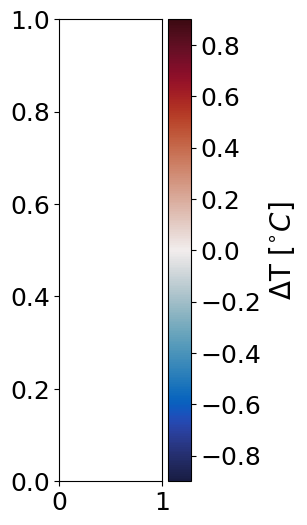

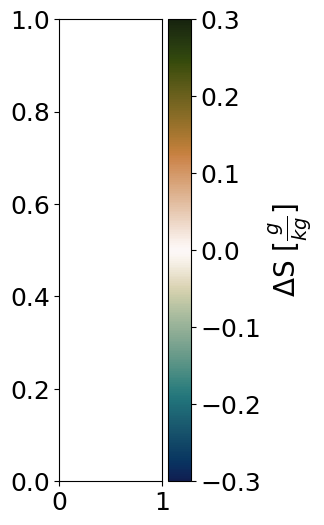

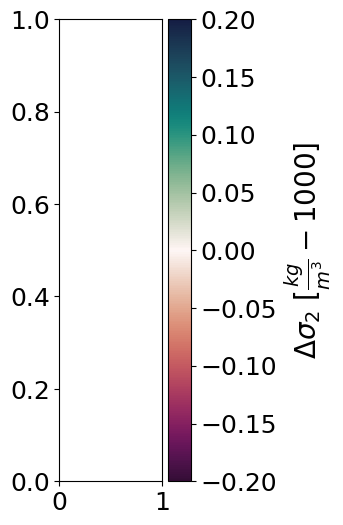

Colorbar figures saved to /home/innag3580/phase1_CONDA/results/colorbars/


In [14]:
# Example data for variable properties (replace with actual data)
labels = [r'$\Delta$T [$^{\circ} C$]', r'$\Delta$S [$\frac{g}{kg}$]', r'$\Delta\sigma_2$ [$\frac{kg}{m^3} -1000$]']
cmaps = [cmo.balance, cmo.tarn_r, cmo.curl_r]
vmins = [-0.9, -0.3, -0.2]
vmaxs = [0.9, 0.3, 0.2]     # Example max values (You can adjust this according to your data)

# Directory to save the colorbar figures
output_dir = os.path.expanduser('~/phase1_CONDA/results/colorbars/')

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)

# Create a figure for each colorbar
for idx, (label, cmap, vmin, vmax) in enumerate(zip(labels, cmaps, vmins, vmaxs)):
    fig, ax = plt.subplots(figsize=(2, 6))
    
    # Create a colormap scalar mappable
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Dummy array for scalar mappable
    
    # Add colorbar to the figure
    cbar = fig.colorbar(sm, ax=ax, fraction=0.3, pad=0.04)
    cbar.set_label(label, fontsize=labelsize)
    
    plt.show()
    
    # Save the colorbar figure
    output_path = os.path.join(output_dir, f'colorbar_{idx + 1}.png')
    fig.savefig(output_path, bbox_inches='tight', dpi=300)
    
    plt.close(fig)

print(f"Colorbar figures saved to {output_dir}")

## Trigger

In [2]:
df = pd.read_csv('1_std_events_dens_spg.csv')

## Occurence

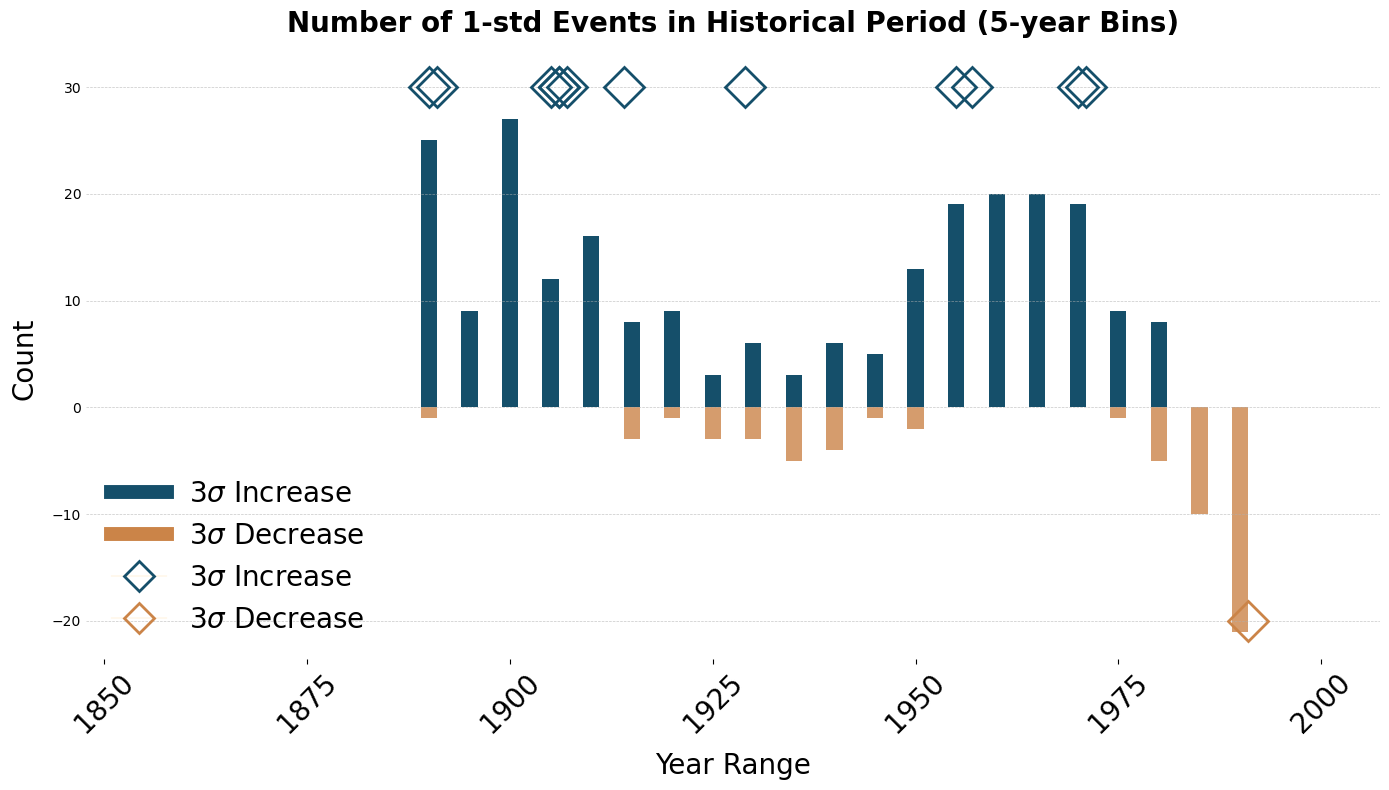

In [29]:
# Add 1850 to all 'Values' to adjust
df['Adjusted_Values'] = df['Values'] + 1850

# Define bins from 1850 to 2010 in steps of 5
bins = range(1850, 2015, 5)
labels = [f"{i} - {i+4}" for i in bins[:-1]]

# Creating the bins in the DataFrame
df['Value_bins'] = pd.cut(df['Adjusted_Values'], bins=bins, labels=labels, include_lowest=True, right=False)

# Filter data based on Condition and count occurrences
value_counts_above = df[df['Condition'] == 'Above']['Value_bins'].value_counts().sort_index()
value_counts_below = df[df['Condition'] == 'Below']['Value_bins'].value_counts().sort_index()

# Adding 1850 to given values
values = np.array([120, 105, 64, 141, 40, 56, 55, 121, 79, 41, 107, 57, 56])
new_values = values + 1850

# Colors
colors = cmo.tarn(np.linspace(0.3, 0.9, 2))

# Create shared font size
font_size = 20

# Configure plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot bar charts
bar_width = 0.4
value_counts_above.plot(kind='bar', ax=ax, color=colors[1], width=bar_width, position=0.5)
(-value_counts_below).plot(kind='bar', ax=ax, color=colors[0], width=bar_width, position=0.5, alpha=0.8)

# Add gridlines
ax.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Title and labels
ax.set_title('Number of 1-std Events in Historical Period (5-year Bins)', fontsize=font_size, weight='bold', pad=20)
ax.set_xlabel('Year Range', fontsize=font_size, labelpad=10)
ax.set_ylabel('Count', fontsize=font_size, labelpad=10)

# Specify x-axis labels
desired_ticks = [1850, 1875, 1900, 1925, 1950, 1975, 2000]
xtick_pos = [labels.index(f"{i} - {i+4}") for i in desired_ticks]
ax.set_xticks(xtick_pos)
ax.set_xticklabels([str(i) for i in desired_ticks], fontsize=font_size, rotation=45)  # Rotate x-tick labels

# Customize spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', length=0)
ax.yaxis.set_ticks_position('none')

# Add markers at specified positions
for value in new_values:
    # Determine the exact x position based on the value
    interval_start = 1850
    interval_width = 5
    bin_start = (value - interval_start) // interval_width * interval_width + interval_start
    bin_index = labels.index(f"{bin_start} - {bin_start+4}")
    exact_x_pos = bin_index + (value - bin_start) / interval_width

    # Determine y position for marker and edge color
    if value == 141 + 1850:
        y_pos = -20
        edge_color = colors[0]
    else:
        y_pos = 30
        edge_color = colors[1]

    # Add the marker
    ax.plot(exact_x_pos, y_pos, marker='D', color='white', markersize=20,
            markeredgewidth=2, markeredgecolor=edge_color, markerfacecolor='none')  # Customize marker style


# Create proxy artists for the markers
marker_above = plt.Line2D([0], [0], marker='D', color='orange', markersize=15, lw=0.1,
                          markeredgewidth=2, markeredgecolor=colors[1], markerfacecolor='none', label=r'3$\sigma$ Increase')
marker_below = plt.Line2D([0], [0], marker='D', color='orange', markersize=15, lw=0.1,
                          markeredgewidth=2, markeredgecolor=colors[0], markerfacecolor='none', label=r'3$\sigma$ Decrease')

# Create proxy artists for bars
bar_above = plt.Line2D([0], [0], color=colors[1], lw=10, label=r'3$\sigma$ Increase',
                       linestyle='-', marker=None)
bar_below = plt.Line2D([0], [0], color=colors[0], lw=10, label=r'3$\sigma$ Decrease',
                       linestyle='-', marker=None)

# Combine both sets of proxy artists into a single legend
handles = [bar_above, bar_below, marker_above, marker_below]
labels = [handle.get_label() for handle in handles]
ax.legend(handles, labels, loc='lower left', fontsize=font_size, frameon=False,facecolor='white', edgecolor='white',)

# Final layout adjustments
plt.tight_layout()

# Show plot
#plt.show()
plt.savefig(os.path.expanduser('~/phase1_CONDA/results/Ocurrences_1_and_3.png'), bbox_inches='tight', dpi=300, transparent=True)